In this notebook we show how to use btk with custom functions. The user can input any selection function,
sampling function or function to change the observation conditions.

In [1]:
import os
import numpy as np
import random
import galsim
import sys
import descwl
import argparse

import copy
%matplotlib notebook
import matplotlib.pyplot as plt

#importing scarlet to make RGB images
#import scarlet.display

sys.path.insert(0,os.path.dirname(os.getcwd()))
import btk
from btk import config
import astropy.table

In [2]:
#Input catalog name
catalog_name = os.path.join(os.path.dirname(os.getcwd()), 'OneDegSq.fits')

In [ ]:
def get_rgb(image, min_val=None, max_val=None):
    """Basic function to normalize 3 band input image to rgb 0-255 image"""
    assert image.shape[0] == 3, "must be 3 channel in dimension 1"
    if min_val is None:
        min_val = image.min(axis=-1).min(axis=-1) 
    if max_val is None:
        max_val = image.max(axis=-1).max(axis=-1) 
    new_image = np.transpose(image, axes=(1,2,0))
    new_image = (new_image - min_val) / (max_val-min_val)*255
    new_image[new_image<0] = 0
    new_image[new_image>255] = 255
    return new_image.astype(np.uint8)

def get_rgb_image(image, normalize_with_image=None):
    """Returns RGB (0-255) image corresponding to the input 3 band image.
    If scarlet.display is imported then the normalization is performed by
    scarlet Asinh function. If not, a basic normalization is performed."""
    if 'scarlet.display' not in sys.modules:
        if normalize_with_image is None:
            min_val = None
            max_val = None
        else:
            min_val = np.min(normalize_with_image, axis=1).min(axis=-1)
            max_val = np.max(normalize_with_image, axis=1).max(axis=-1)
        img_rgb = get_rgb(image, min_val=min_val, max_val=max_val)
    else:
        norm = scarlet.display.Asinh(img=normalize_with_image, Q=20)
        img_rgb = scarlet.display.img_to_rgb(image, norm=norm)
    return img_rgb

def plot_blends( blend_images, blend_list, detected_centers=None, limits=None):
    """Plots blend images as RGB(g,r,i) image, sum in all bands, and RGB with centers of objects marked"""
    batch_size = len(blend_list)
    if detected_centers is None:
        detected_centers = [[]]*batch_size
    for i in range(batch_size):    
        num = len(blend_list[i])
        images = np.transpose(blend_images[i, :, :, 1:4], axes=(2,0,1))
        blend_img_rgb = get_rgb_image(images)
        plt.figure(figsize=(8,3))
        plt.subplot(131)
        plt.imshow(blend_img_rgb)
        if limits:
            plt.xlim(limits)
            plt.ylim(limits)
        plt.title("gri bands")
        plt.axis('off')
        plt.subplot(132)
        plt.imshow(np.sum(blend_images[i, :, :, :], axis=2))
        plt.title("Sum")
        if limits:
            plt.xlim(limits)
            plt.ylim(limits)
        plt.axis('off')

        plt.subplot(133)
        plt.imshow(blend_img_rgb)
        plt.title("%i objects with centers"%num)
        for entry in blend_list[i]:
            plt.plot(entry['dx'], entry['dy'],'rx')
        if limits:
            plt.xlim(limits)
            plt.ylim(limits)
        for cent in detected_centers[i]:
            plt.plot(cent[0], cent[1],'go', fillstyle='none')
        plt.axis('off')
        plt.show()

## Custom sampling
Number of galaxies in each blend is modelled as a poisson distribution of mean 3. Distance between the galaxies are a normal distribution of 1 arsc sec standard deviation.


In [4]:
# new sampling functions

def new_center_shift(Args, number_of_objects):
    """Set shift in galaxy centers from a normal distribution with mean 0 and std 1 arcseconds"""
    mean, sigma = 0, 1 #arcseconds
    dx = np.random.normal(mean, sigma, number_of_objects)
    dy = np.random.normal(mean, sigma, number_of_objects)
    return dx, dy
    
def new_sampling_function(Args, catalog):
    """ Samples galaxies with i<24, r-i>1. Number of objects ber blend is selected from a poisson
    distribution of mean 3. The number of objects is restricted to max_number. The centers of the objects 
    are set in new function new_center_shift()
    Note:Sampling function must clip the number of objects to Args.max_number!
    """
    # Set number of objets per blend
    number_of_objects = np.random.poisson(3)
    number_of_objects = np.minimum(number_of_objects, Args.max_number)
    
    # Make galaxy sample
    q, = np.where((catalog['i_ab'] <= 24) & (np.abs(catalog['i_ab'] - catalog['r_ab']) >1))
    blend_catalog = catalog[np.random.choice(q, size=number_of_objects)]
    
    # galaxy centers are sent as random shift from 0,0
    blend_catalog['ra'], blend_catalog['dec'] = 0., 0.
    dx, dy = new_center_shift(Args, number_of_objects)
    blend_catalog['ra'] += dx
    blend_catalog['dec'] += dy
    return blend_catalog

In [5]:
# Load parameters
param = config.Simulation_params(catalog_name, max_number=6, batch_size=5)
np.random.seed(param.seed)

#Load input catalog
catalog = btk.get_input_catalog.load_catalog(param)

#Generate catlogs of blended objects 
blend_genrator = btk.create_blend_generator.generate(param, catalog, new_sampling_function)

#Generates observing conditions for the selected survey_name and all input bands
observing_genrator = btk.create_observing_generator.generate(param)

#Generate images of blends in all the observing bands
draw_blend_generator = btk.draw_blends.generate(param, blend_genrator, observing_genrator)    

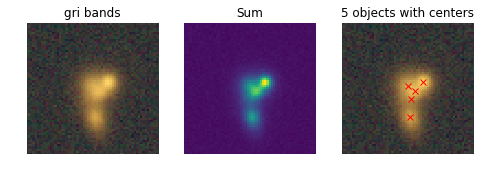

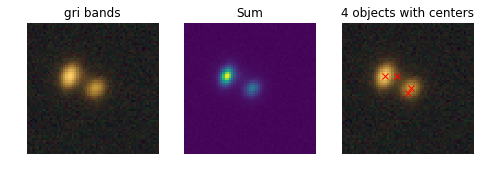

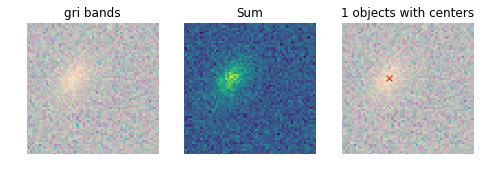

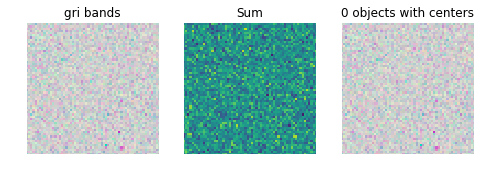

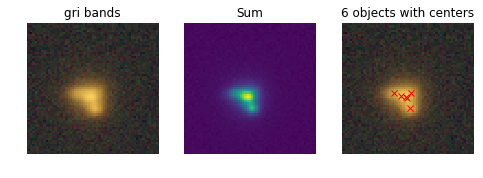

In [6]:
# This cell generates new batch_size number of blends each time it's executed

# Draw blend
blend_results = next(draw_blend_generator)
output = blend_results
blend_images = output['blend_images']
isolated_images = output['isolated_images']
blend_list = output['blend_list']

# Plot blended images
plot_blends(blend_images, blend_list, limits=(30,90))

## Blends drawn as galaxies part of a group detremined by wld

Use real galaxy blend configurations from the input Catsim-like catalog. The catalog has already been run with WLD in the r band, without generating images. This catalog *wld_1sqdeg_lsst_i_catalog.fits* denotes galaxies that belong to groups. See WLD [documentation](https://weaklensingdeblending.readthedocs.io/en/latest/index.html) to find out how this is computed.

We define a `group_sampling_function` to pick groups from this catalog and draw them.


In [7]:
import astropy.table

In [8]:
def get_random_shift(Args, number_of_objects, maxshift=None):
    """Returns a random shift from the center in x and y coordinates
    between 0 and max-shift (in arcseconds).
    """
    if not maxshift:
        maxshift = Args.stamp_size / 30.  # in arcseconds
    dx = np.random.uniform(-maxshift, maxshift,
                           size=number_of_objects)
    dy = np.random.uniform(-maxshift, maxshift,
                           size=number_of_objects)
    return dx, dy

def group_sampling_function(Args, catalog):
    """Blends are defined from *groups* of galaxies from the Cat-Sim like
    catalog previously analyzed with WLD. Function selects galaxies
    Note: the pre-run WLD images are not used here. We only use the pre-run
    catalog (in i band) to identify galaxies that belong to a group.

    Randomly picks entries from input catalog that are brighter than 25.3
    mag in the i band. The centers are randomly distributed within 1/5 of the
    stamp size.
    """
    if not hasattr(Args, 'wld_catalog'):
        raise Exception(
            "A pre-run WLD catalog should be input as Args.wld_catalog")
    else:
        wld_catalog = Args.wld_catalog 
    group_ids = np.unique(wld_catalog['grp_id'][wld_catalog['grp_size'] >= 5])
    group_id = np.random.choice(group_ids)
    ids = wld_catalog['db_id'][wld_catalog['grp_id'] == group_id]
    blend_catalog = astropy.table.vstack([catalog[catalog['galtileid'] == i] for i in ids])
    blend_catalog['ra'] -= np.mean(blend_catalog['ra'])
    blend_catalog['dec'] -= np.mean(blend_catalog['dec'])
    # convert ra dec from degrees to arcsec
    blend_catalog['ra'] *= 3600
    blend_catalog['dec'] *= 3600
    # Add small shift so that center does not perfectly align with stamp center
    dx, dy = get_random_shift(Args, 1, maxshift=3*Args.pixel_scale)
    blend_catalog['ra'] += dx
    blend_catalog['dec'] += dy
    # make sure galaxy centers don't lie too close to edge
    cond1 = np.abs(blend_catalog['ra']) < Args.stamp_size/2. - 3
    cond2 = np.abs(blend_catalog['dec']) < Args.stamp_size/2. - 3
    no_boundary = blend_catalog[cond1 & cond2]
    if len(no_boundary) == 0:
        return no_boundary
    # make sure number of galaxies in blend is less than Args.max_number
    num = min([len(no_boundary), Args.max_number])
    select = np.random.choice(range(len(no_boundary)), num, replace=False)
    return no_boundary[select]

def basic_selection_function(catalog):
    """Apply selection cuts to the input catalog"""
    a = np.hypot(catalog['a_d'], catalog['a_b'])
    q, = np.where((a <= 2) & (catalog['i_ab'] <= 26))
    return catalog[q]

In [9]:
# Load catalog reviously run through WLD
wld_catalog_name = os.path.join(os.path.dirname(os.getcwd()), 'wld_1sqdeg_lsst_i_catalog.fits')
wld_catalog = astropy.table.Table.read(wld_catalog_name, format='fits')
selected_gal = wld_catalog[
    (wld_catalog['sigma_m'] < 2 )  & (wld_catalog['ab_mag'] < 28 )]

In [10]:
param = config.Simulation_params(catalog_name, max_number=10, batch_size=4)
param.wld_catalog = selected_gal

np.random.seed(param.seed)
# Load input catalog
catalog = btk.get_input_catalog.load_catalog(param, selection_function=basic_selection_function)

# Generate catlogs of blended objects. 
# Input group_sampling_function here
blend_generator = btk.create_blend_generator.generate(param, catalog, group_sampling_function)

#Generates observing conditions for the selected survey_name and all input bands
observing_generator = btk.create_observing_generator.generate(param)

#Generate images of blends in all the observing bands
draw_blend_generator = btk.draw_blends.generate(param, blend_generator, observing_generator) 

Source not visible


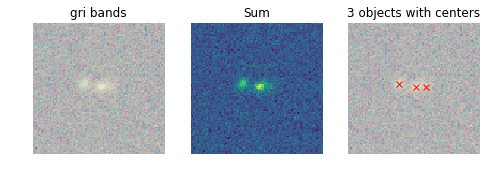

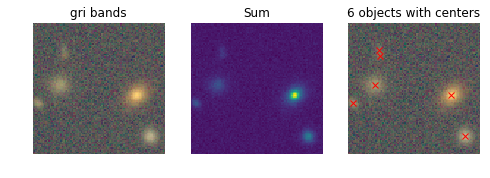

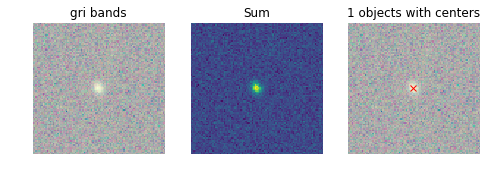

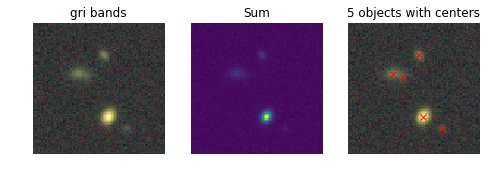

In [11]:
# This cell generates new batch_size number of blends each time it's executed

# Draw blend
blend_results = next(draw_blend_generator)
output = blend_results
blend_images = output['blend_images']
isolated_images = output['isolated_images']
blend_list = output['blend_list']

# Plot blended images
plot_blends(blend_images, blend_list, limits=(15,105))

## Using custom observing condition

Here we define a `custom_obs_condition` that selects different observing condition for each band and blend. Each blend in the batch will have different seeing (atmosphere effects) and PSF (telescope effects). 

To show this we input a catalog with just 1 galaxy, so that our batch has the same object.

In [12]:
def custom_obs_condition(Args, band):
    """Returns observing conditions from the WLD package
    for a given survey_name and band with a small offset from
    the default parametrs.
    Args
        Args: Class containing parameters to generate blends
        band: filter name to get observing conditions for.
    Returns
        survey: WLD survey class with observing conditions.
    """
    survey = descwl.survey.Survey.get_defaults(
        survey_name=Args.survey_name,
        filter_band=band)
    survey['exposure_time'] = random.uniform(100,survey['exposure_time'])
    #survey['exposure_time'] += random.uniform(-4000, 4000)
    survey['zenith_psf_fwhm'] += random.uniform(-0.1,0.1)
    return survey

def plot_blends_same_scale(blend_images, blend_list, detected_centers=None, limits=None):
    """Plots blend images as RGB(g,r,i) image, and i band image"""
    batch_size = len(blend_list)
    if detected_centers is None:
        detected_centers = [[]]*batch_size
    norm = scarlet.display.Asinh(img=np.transpose(blend_images[0, :, :, 1:4], axes=(2,0,1)),
                                 Q=20)
    vmin, vmax = np.min(blend_images[0, :, :, 3]), np.max(blend_images[0, :, :, 3])
    for i in range(batch_size):    
        num = len(blend_list[i])
        images = np.transpose(blend_images[i, :, :, 1:4], axes=(2,0,1))
        blend_img_rgb = scarlet.display.img_to_rgb(images, norm=norm)
        plt.figure(figsize=(6,3))
        plt.subplot(121)
        plt.imshow(blend_img_rgb)
        if limits:
            plt.xlim(limits)
            plt.ylim(limits)
        plt.title("gri bands")
        plt.axis('off')
        plt.subplot(122)
        plt.imshow(blend_images[i, :, :, 3],
                  vmin=vmin, vmax=vmax)
        plt.title("i band")
        if limits:
            plt.xlim(limits)
            plt.ylim(limits)
        plt.axis('off')


In [13]:
param = config.Simulation_params(catalog_name, max_number=2, batch_size=4)
np.random.seed(param.seed)
random.seed(param.seed)
#Load input catalog
catalog = btk.get_input_catalog.load_catalog(param, selection_function=basic_selection_function)
catalog = catalog[catalog['i_ab']<23][13:14]
#Generate catlogs of blended objects 
blend_generator = btk.create_blend_generator.generate(param, catalog)

#Generates observing conditions for the selected survey_name and all input bands
observing_generator = btk.create_observing_generator.generate(param, obs_function=custom_obs_condition)

#Generate images of blends in all the observing bands
draw_blend_generator = btk.draw_blends.generate(param, blend_generator, observing_generator) 

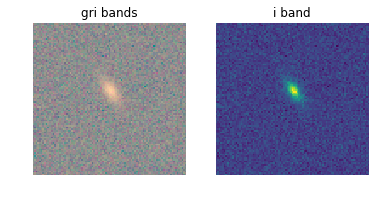

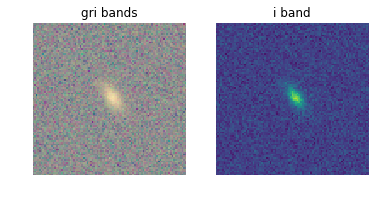

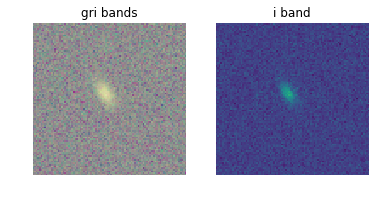

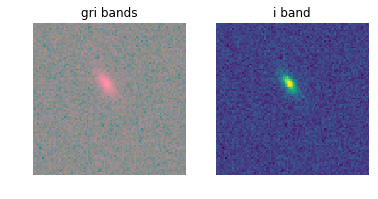

In [14]:
# Same galaxy is drawn with different observing conditions. All image shave same color scale. 

# This cell generates new batch_size number of blends each time it's executed

# Draw blend
blend_results = next(draw_blend_generator)
output = blend_results
blend_images = output['blend_images']
isolated_images = output['isolated_images']
blend_list = output['blend_list']

# Plot blended images
plot_blends_same_scale(blend_images, blend_list, limits=(15,105))